# Moving To Richmond

In [1]:
##!conda install -c anaconda beautifulsoup4 -y
##!conda install -c anaconda lxml -y
##!conda install -c anaconda requests -y
##!conda config --add channels conda-forge
##!conda install -c conda-forge geopy --yes
##!conda install -c conda-forge folium=0.5.0 --yes
##  imports and functions
from project_lib import Project
from bs4 import BeautifulSoup
import requests
import lxml
import csv
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy import distance
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML     
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
#import folium # plotting library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
RVA_Cities =['richmond, va','chesterfield, va', 'midlothian, va', 'henrico, va', 'glen allen, va', 'ashland, va','chamberlayne, va', 'mechanicsville, va']


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
zipfile = pd.read_csv("https://move-econresearch-prod.s3-us-west-2.amazonaws.com/listings/core/current_month/RDC_Inventory_Core_Metrics_Zip_Current.csv")

In [5]:
zip2 = zipfile[['postal_code','zip_name', 'median_listing_price','average_listing_price','new_listing_count','active_listing_count','total_listing_count','price_reduced_count','median_days_on_market']]
##zip2.head()
##rva_price = zip2[zip2['median_listing_price'] < 360000] 
##rva_df = rva_price.loc[rva_price['zip_name'].isin(RVA_Cities)]
rva_df = zip2.loc[zip2['zip_name'].isin(RVA_Cities)]
rva_df.rename(columns={'postal_code': 'ZipCode'},inplace=True)
rva_df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


(27, 9)

In [6]:
##Use geopy library to get the latitude and longitude values of new jobs address
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(new_job_addr)
nja_latitude = location.latitude
nja_longitude = location.longitude
print('The geograpical coordinates of Job location are {}, {}.'.format( nja_latitude, nja_longitude))
print(location.raw['display_name'])

The geograpical coordinates of Job location are 37.60536995, -77.5272805050902.
7100, Forest Avenue, Laurel, Crestview, Henrico County, Virginia, 23226, United States of America


In [7]:
coords = []
 
geolocator = Nominatim(user_agent="my-application")
for zipcode, city in zip(rva_df['ZipCode'],rva_df['zip_name'] ):
    location = geolocator.geocode({"postalcode": zipcode, "state": 'VA'})
    latitude2 = location.latitude
    longitude2 = location.longitude
    ##print(location)
    miles = distance.distance((nja_latitude,nja_longitude),(latitude2,longitude2)).mi
    #print(round(miles))
    coords.append((
        zipcode,
        latitude2,
        longitude2,
        miles,
        location.raw['display_name']))

In [8]:
# dconvert the list into a new DataFrame
coords_df = pd.DataFrame(coords)
#define the column names
coords_df.columns = ['ZipCode','Latitude', 'Longitude', 'Distance','display_name']

##print(coords_df.shape)
##coords_df

In [9]:
mylist = coords_df['display_name'].to_list()
cleaner = []
for row in mylist:
    x = row.split(',')
    cleaner.append((x.pop(0)))
coords_df['display_name'] = pd.Series(cleaner)
coords_df

,ZipCode,Latitude,Longitude,Distance,display_name
0,23060,37.657968,-77.529652,3.629803,Henrico County
1,23223,37.550750,-77.388059,8.519557,East Highland Park
2,23005,37.745020,-77.474184,10.061280,Ashland
3,23221,37.563804,-77.489576,3.535487,Richmond City
4,23225,37.518329,-77.504432,6.132441,Richmond City
5,23220,37.555701,-77.452632,5.340452,Richmond City
6,23229,37.595856,-77.565052,2.173955,Tuckahoe
7,23233,37.638190,-77.618639,5.499002,Henrico County
8,23112,37.423764,-77.649894,14.220709,Chesterfield County
9,23224,37.491457,-77.478117,8.306879,Richmond City


In [9]:


# create map
map_zip = folium.Map(location=[nja_latitude, nja_longitude], zoom_start=12)

label = '7100 Forest Ave 23226'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [nja_latitude, nja_longitude],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#FDBB84',
    fill_opacity=0.7).add_to(map_zip)  

 
for lat, lng, zipcode, dispname in zip(coords_df['Latitude'], coords_df['Longitude'],coords_df['ZipCode'], coords_df['display_name']):
    label = '{}, {}'.format(dispname, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_zip)        
map_zip

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
##get the area info for goods and services
## Foursquare API required inputs
VERSION = '20180604'
LIMIT = 100
radius = 5000
venue_list = []

##loop thru and get info from 4square
for lat, lng, zipcode, dispname in zip(coords_df['Latitude'], coords_df['Longitude'],coords_df['ZipCode'], coords_df['display_name']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()

    items = results['response']['groups'][0]['items']
    ##print(items)
    ##break
    for venue in items:
        try:
            venue_list.append(( 
                zipcode,
                dispname, 
                venue['venue']['name'], 
                venue['venue']['location']['address'],
                venue['venue']['categories'][0]['name']))
        except:
            continue

In [12]:
# dconvert the venue list into a new DataFrame
venues_df = pd.DataFrame(venue_list)
#define the column names
venues_df.columns = ['ZipCode','Display_Name', 'VenueName', 'VenueAddress', 'Category']

print(venues_df.shape)


(2386, 5)


In [13]:
print('There are {} uniques categories.'.format(len(venues_df['Category'].unique())))
##print(venues_df['Category'].unique())

There are 219 uniques categories.


In [14]:
rva_gs = ['Grocery Store', 'Supermarket','Drugstore', 'Pharmacy', 'Market','Pet Store', 'Coffee Shop', 'Wine Shop','Gym / Fitness Center','Salon / Barbershop','Gym','Farmers Market', 'Food & Drink Shop', 'Performing Arts Venue','Museum', 'Theater','Art Museum','Dog Run','Social Club','State / Provincial Park', 'Lake']
##rva_gs = ['Grocery Store', 'Veterinarian Service', 'Medical']
##reduce the number of categories to the ones of interest
rva_ven = venues_df.loc[venues_df['Category'].isin(rva_gs)]
rva_ven['Category'].loc[rva_ven['Category']== 'Grocery Store'] = 'Supermarket'
rva_ven['Category'].loc[rva_ven['Category']== 'Drugstore'] = 'Pharmacy'
rva_ven['Category'].loc[rva_ven['Category']== 'Gym / Fitness Center'] = 'Gym'
print(rva_ven.shape)

(383, 5)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
###group everything up and see what is where
rva_onehot = pd.get_dummies(rva_ven[['Category']], prefix="", prefix_sep="")

#print one hot totals
print( rva_onehot.sum(axis = 0, skipna = True))

# add zipcode and name column back to dataframe
 
rva_onehot['ZipCode'] = rva_ven['ZipCode'] 


#  zipcode and displayname column to the first column
fixed_columns = list(rva_onehot.columns[-2:]) + list(rva_onehot.columns[:-2])
rva_onehot = rva_onehot[fixed_columns]

print("OneHot Shape: {}".format(rva_onehot.shape))
##rva_onehot.head()

rva_grouped = rva_onehot.groupby(['ZipCode']).sum().reset_index()

print("Grouped Shape: {}".format(rva_grouped.shape))
##print(rva_grouped)

Art Museum                  3
Coffee Shop                80
Dog Run                     4
Farmers Market             10
Food & Drink Shop           3
Gym                        73
Market                      5
Museum                      4
Performing Arts Venue       6
Pet Store                  14
Pharmacy                   45
Salon / Barbershop         20
Social Club                 1
State / Provincial Park     1
Supermarket                95
Theater                     3
Wine Shop                  16
dtype: int64
OneHot Shape: (383, 18)
Grouped Shape: (26, 18)


In [16]:
##of the venues of interest what are we most likely to find in the zipcodea

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['ZipCode'] = rva_grouped['ZipCode']

for ind in np.arange(rva_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rva_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,23005,Coffee Shop,Pharmacy,Supermarket,Wine Shop,Salon / Barbershop
1,23059,Supermarket,Coffee Shop,Gym,Pharmacy,Salon / Barbershop
2,23060,Supermarket,Coffee Shop,Wine Shop,Salon / Barbershop,Pharmacy
3,23111,Supermarket,Gym,Coffee Shop,Salon / Barbershop,Pharmacy
4,23112,Gym,Coffee Shop,Supermarket,Pet Store,Pharmacy
5,23113,Coffee Shop,Gym,Supermarket,Salon / Barbershop,Pharmacy
6,23114,Coffee Shop,Pharmacy,Supermarket,Gym,Salon / Barbershop
7,23116,Gym,Supermarket,Coffee Shop,Salon / Barbershop,Pharmacy
8,23220,Coffee Shop,Gym,Performing Arts Venue,Theater,Art Museum
9,23221,Coffee Shop,Gym,Supermarket,Museum,Art Museum


In [18]:
## compare to most common place of all places
venues_df['Category'].loc[venues_df['Category']== 'Grocery Store'] = 'Supermarket'
venues_df['Category'].loc[venues_df['Category']== 'Drugstore'] = 'Pharmacy'
venues_df['Category'].loc[venues_df['Category']== 'Gym / Fitness Center'] = 'Gym'

rva_onehot2 = pd.get_dummies(venues_df[['Category']], prefix="", prefix_sep="")

#print( rva_onehot2.sum(axis = 0, skipna = True))
# add zipcode and displayname column back to dataframe
 
rva_onehot2['ZipCode'] = venues_df['ZipCode'] 
rva_onehot2['Display_Name'] = venues_df['Display_Name']

#  zipcode and displayname column to the first column
fixed_columns = list(rva_onehot2.columns[-2:]) + list(rva_onehot2.columns[:-2])
rva_onehot2 = rva_onehot2[fixed_columns]

print(rva_onehot2.shape)
##rva_onehot2.head()

rva_grouped2 = rva_onehot2.groupby(['ZipCode']).sum().reset_index()

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['ZipCode'] = rva_grouped2['ZipCode']

for ind in np.arange(rva_grouped2.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rva_grouped2.iloc[ind, :], num_top_venues)

postcode_venues_sorted

(2386, 218)


,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,23005,Fast Food Restaurant,Gas Station,Pizza Place,Sandwich Place,Hotel
1,23059,American Restaurant,Hotel,Mexican Restaurant,Supermarket,Convenience Store
2,23060,Supermarket,Pizza Place,Mexican Restaurant,Hotel,Sushi Restaurant
3,23111,Mexican Restaurant,Italian Restaurant,Sandwich Place,American Restaurant,Gym
4,23112,Italian Restaurant,Mexican Restaurant,American Restaurant,Gym,Coffee Shop
5,23113,Gym,Coffee Shop,Supermarket,Mexican Restaurant,Fast Food Restaurant
6,23114,Coffee Shop,Clothing Store,Supermarket,Pharmacy,Mexican Restaurant
7,23116,Gym,Supermarket,Italian Restaurant,Café,Convenience Store
8,23220,American Restaurant,Coffee Shop,Breakfast Spot,Sandwich Place,Pizza Place
9,23221,Brewery,American Restaurant,Coffee Shop,Greek Restaurant,Pizza Place


In [18]:
#Now lets look at the real estate 
rva_df.corr()

,median_listing_price,average_listing_price,new_listing_count,active_listing_count,total_listing_count,price_reduced_count,median_days_on_market
median_listing_price,1.000000,0.928699,0.579963,0.517832,0.469002,0.359402,-0.022861
average_listing_price,0.928699,1.000000,0.612947,0.616783,0.584275,0.396340,0.141052
new_listing_count,0.579963,0.612947,1.000000,0.908254,0.896760,0.756276,-0.142638
active_listing_count,0.517832,0.616783,0.908254,1.000000,0.977217,0.843362,0.125615
total_listing_count,0.469002,0.584275,0.896760,0.977217,1.000000,0.760577,0.215552
price_reduced_count,0.359402,0.396340,0.756276,0.843362,0.760577,1.000000,-0.113672
median_days_on_market,-0.022861,0.141052,-0.142638,0.125615,0.215552,-0.113672,1.000000


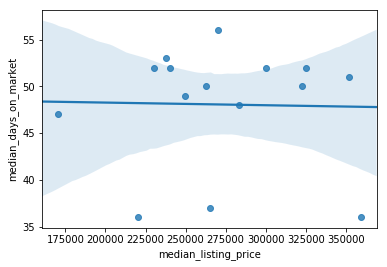

In [31]:
sns.regplot(x="median_listing_price", y="median_days_on_market", data=rva_df)

In [ ]:
##

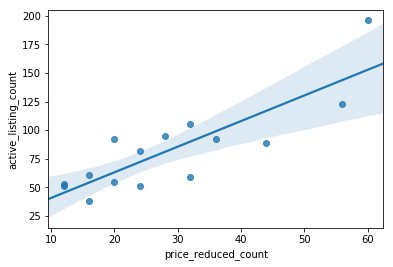

In [21]:
sns.regplot(x="price_reduced_count", y="active_listing_count", data=rva_df)

In [18]:
rva_merged = pd.merge(rva_df, rva_grouped, how='left',
        on='ZipCode', validate="1:1")
rva_merged.head()
##write results to csv to import into excel or other uses for later
##project.save_data(file_name = "merged_data.csv",data = rva_merged.to_csv(index=False))


,ZipCode,zip_name,median_listing_price,average_listing_price,new_listing_count,active_listing_count,total_listing_count,price_reduced_count,median_days_on_market,Wine Shop,...,Gym,Market,Museum,Performing Arts Venue,Pet Store,Pharmacy,Salon / Barbershop,Social Club,Supermarket,Theater
0,23060,"glen allen, va",359550.0,365899.0,48.0,92.0,165.0,36.0,36.0,1,...,1,0,0,0,1,1,1,0,4,0
1,23223,"richmond, va",249950.0,263672.0,44.0,123.0,212.0,56.0,49.0,0,...,4,0,1,2,0,1,0,0,0,0
2,23225,"richmond, va",265050.0,265649.0,32.0,51.0,106.0,24.0,37.0,1,...,0,0,0,0,0,1,1,0,5,0
3,23112,"midlothian, va",352040.0,402848.0,68.0,196.0,361.0,60.0,51.0,0,...,5,0,0,0,2,1,0,0,3,0
4,23224,"richmond, va",170050.0,225537.0,24.0,53.0,121.0,12.0,47.0,0,...,1,0,0,0,0,5,1,0,4,0


In [19]:
rva_merged.corr()

,median_listing_price,average_listing_price,new_listing_count,active_listing_count,total_listing_count,price_reduced_count,median_days_on_market,Wine Shop,Art Museum,Coffee Shop,...,Gym,Market,Museum,Performing Arts Venue,Pet Store,Pharmacy,Salon / Barbershop,Social Club,Supermarket,Theater
median_listing_price,1.000000,0.928699,0.579963,0.517832,0.469002,0.359402,-0.022861,-0.069275,-0.039855,0.213162,...,0.233445,-0.175311,-0.253503,-0.253503,0.444639,-0.380150,0.197850,-0.013388,-0.001936,-0.175311
average_listing_price,0.928699,1.000000,0.612947,0.616783,0.584275,0.396340,0.141052,-0.185024,-0.137325,0.215391,...,0.343423,-0.047635,-0.240364,-0.240364,0.474144,-0.359911,0.162514,0.115457,-0.176010,-0.047635
new_listing_count,0.579963,0.612947,1.000000,0.908254,0.896760,0.756276,-0.142638,-0.069195,-0.067374,0.072615,...,0.211090,-0.301130,0.035956,0.035956,0.387266,-0.526921,-0.215188,-0.251123,-0.146439,-0.301130
active_listing_count,0.517832,0.616783,0.908254,1.000000,0.977217,0.843362,0.125615,-0.282616,-0.221858,0.033297,...,0.370462,-0.197612,0.237544,0.237544,0.333504,-0.515266,-0.245822,-0.312555,-0.359280,-0.197612
total_listing_count,0.469002,0.584275,0.896760,0.977217,1.000000,0.760577,0.215552,-0.353702,-0.248622,-0.062909,...,0.356486,-0.197202,0.144475,0.144475,0.332009,-0.384688,-0.285381,-0.257245,-0.257889,-0.197202
price_reduced_count,0.359402,0.396340,0.756276,0.843362,0.760577,1.000000,-0.113672,-0.017972,-0.089087,0.153462,...,0.385367,0.032686,0.577453,0.577453,0.371391,-0.705223,-0.483850,-0.237566,-0.594310,0.032686
median_days_on_market,-0.022861,0.141052,-0.142638,0.125615,0.215552,-0.113672,1.000000,-0.546390,-0.475264,-0.409926,...,0.585940,0.373959,0.153365,0.153365,-0.246669,0.309793,-0.166188,0.340702,-0.245347,0.373959
Wine Shop,-0.069275,-0.185024,-0.069195,-0.282616,-0.353702,-0.017972,-0.546390,1.000000,0.201737,0.433660,...,0.098097,0.296068,-0.021148,-0.021148,0.260313,-0.480450,-0.176090,0.201737,-0.015484,0.296068
Art Museum,-0.039855,-0.137325,-0.067374,-0.221858,-0.248622,-0.089087,-0.475264,0.201737,1.000000,0.521124,...,-0.425481,-0.104828,-0.104828,-0.104828,-0.198517,-0.190975,0.218218,-0.071429,0.211071,-0.104828
Coffee Shop,0.213162,0.215391,0.072615,0.033297,-0.062909,0.153462,-0.409926,0.433660,0.521124,1.000000,...,0.101626,0.167300,-0.071700,-0.071700,0.203671,-0.373938,0.149256,0.032570,-0.008750,0.167300


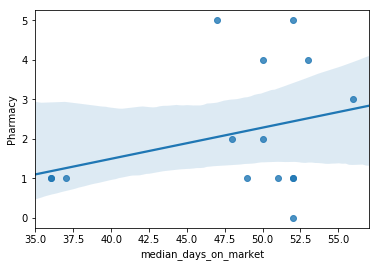

In [26]:
sns.regplot(x="median_days_on_market", y="Pharmacy", data=rva_merged)

In [25]:
rva_merg2 = pd.merge(rva_df, coords_df, how='left',
        on='ZipCode', validate="1:1")
rva_merg_x = rva_merg2[{'median_listing_price','active_listing_count','median_days_on_market','Distance' }]
rva_merg_x.corr()

,median_listing_price,Distance,median_days_on_market,active_listing_count
median_listing_price,1.000000,0.163062,-0.022861,0.517832
Distance,0.163062,1.000000,0.598622,0.384565
median_days_on_market,-0.022861,0.598622,1.000000,0.125615
active_listing_count,0.517832,0.384565,0.125615,1.000000


In [26]:
rva_z = rva_merg2[['ZipCode','zip_name','display_name','Distance','median_listing_price','active_listing_count','median_days_on_market']]
rva_z.sort_values('median_listing_price')

,ZipCode,zip_name,display_name,Distance,median_listing_price,active_listing_count,median_days_on_market
4,23224,"richmond, va",Richmond City,8.306879,170050.0,53.0,47.0
13,23228,"henrico, va",Lakeside,2.236781,220050.0,59.0,36.0
9,23222,"richmond, va",Richmond City,5.990948,230045.0,89.0,52.0
12,23237,"richmond, va",Chesterfield County,14.539558,237500.0,51.0,53.0
8,23234,"richmond, va",Chesterfield County,11.270492,240000.0,61.0,52.0
1,23223,"richmond, va",East Highland Park,8.519557,249950.0,123.0,49.0
5,23231,"henrico, va",Henrico County,12.382579,262780.0,95.0,50.0
2,23225,"richmond, va",Richmond City,6.132441,265050.0,51.0,37.0
10,23227,"richmond, va",Henrico County,4.489205,270040.0,38.0,56.0
14,23235,"richmond, va",Bon Air,6.843039,283357.0,82.0,48.0
